In [1]:
import sys
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
from sklearn.metrics import accuracy_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.linear_model import LogisticRegression
from transformers import AutoTokenizer

import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9

sys.path.append('../../')

from src.preprocessing import DataPreprocessor, FEATURES, create_phoneme_map
from src.config import DataPreprocessingParams, DatasetParams
from src.models.gpt2 import GPT2LMHeadModel
from src.utils import setup

MODEL_NAME = 'phonemetransformers/childes-multilingual-5M-gpt2_lm-model'


In [5]:
import subprocess
import os

TMP_DIR = 'tmp'

def get_commits(repo_url):
    if not os.path.exists('tmp'):
        print(f"Cloning repository from {repo_url} into {TMP_DIR}...")
        subprocess.run(['git', 'clone', repo_url, TMP_DIR], check=True)
    else:
        print(f"Repository already exists at {TMP_DIR}.")

    os.chdir('tmp')  # Change to the repository directory
    print(f"Checking out repository...")
    subprocess.run(['git', 'checkout', 'main'], check=True)
    print("Finding all commit messages...")
    log = subprocess.run(['git', 'log', '--grep=Final model for experiment'], stdout=subprocess.PIPE, check=True)
    hashes = [line.split()[1] for line in log.stdout.decode().split('\n') if line.startswith('commit')]
    languages = [line.split()[-1] for line in log.stdout.decode().split('\n') if 'Final model for experiment' in line]
    print(f"Found {len(hashes)} final models in git history.")
    os.chdir('..')  # Change back to the parent
    print(f"Removing repository directory {TMP_DIR}...")
    subprocess.run(['rm', '-rf', TMP_DIR], check=True)
    return dict(zip(languages, hashes))

model_commits = get_commits( f'https://huggingface.co/{MODEL_NAME}.git')

Cloning repository from https://huggingface.co/phonemetransformers/childes-multilingual-5M-gpt2_lm-model.git into tmp...


Cloning into 'tmp'...


Checking out repository...
Your branch is up to date with 'origin/main'.
Finding all commit messages...
Found 11 final models in git history.
Removing repository directory tmp...


Already on 'main'


## Load Model & Tokenizer

In [6]:
models = {}
tokenizers = {}
for language, commit in model_commits.items():
    model = GPT2LMHeadModel.from_pretrained(MODEL_NAME, revision=commit)
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, revision=commit)
    models[language] = model
    tokenizers[language] = tokenizer

## Load Phoible


In [7]:
phoible = pd.read_csv('../../data/phoible.csv', sep=',', encoding='utf-8')
phoneme_maps = {language : create_phoneme_map(tokenizer, '../../data/phoible.csv', convert_to_numeric=True) for language, tokenizer in tokenizers.items()}


/var/folders/nz/6tzh0bsj2txd1cz18gpcms_c0000gn/T/ipykernel_72347/4204385596.py:1: DtypeWarning: Columns (4,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/PhonemeTransformers/analysis/representations/../../src/preprocessing.py:64: DtypeWarning: Columns (4,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/PhonemeTransformers/analysis/representations/../../src/preprocessing.py:64: DtypeWarning: Columns (4,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/PhonemeTransformers/analysis/representations/../../src/preprocessing.py:64: DtypeWarning: Columns (4,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.
/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/PhonemeTransfo

/Users/zebulongoriely/Documents/UniDocs/PHD/research/projects/PhonemeTransformers/analysis/representations/../../src/preprocessing.py:64: DtypeWarning: Columns (4,7,8,11) have mixed types. Specify dtype option on import or set low_memory=False.


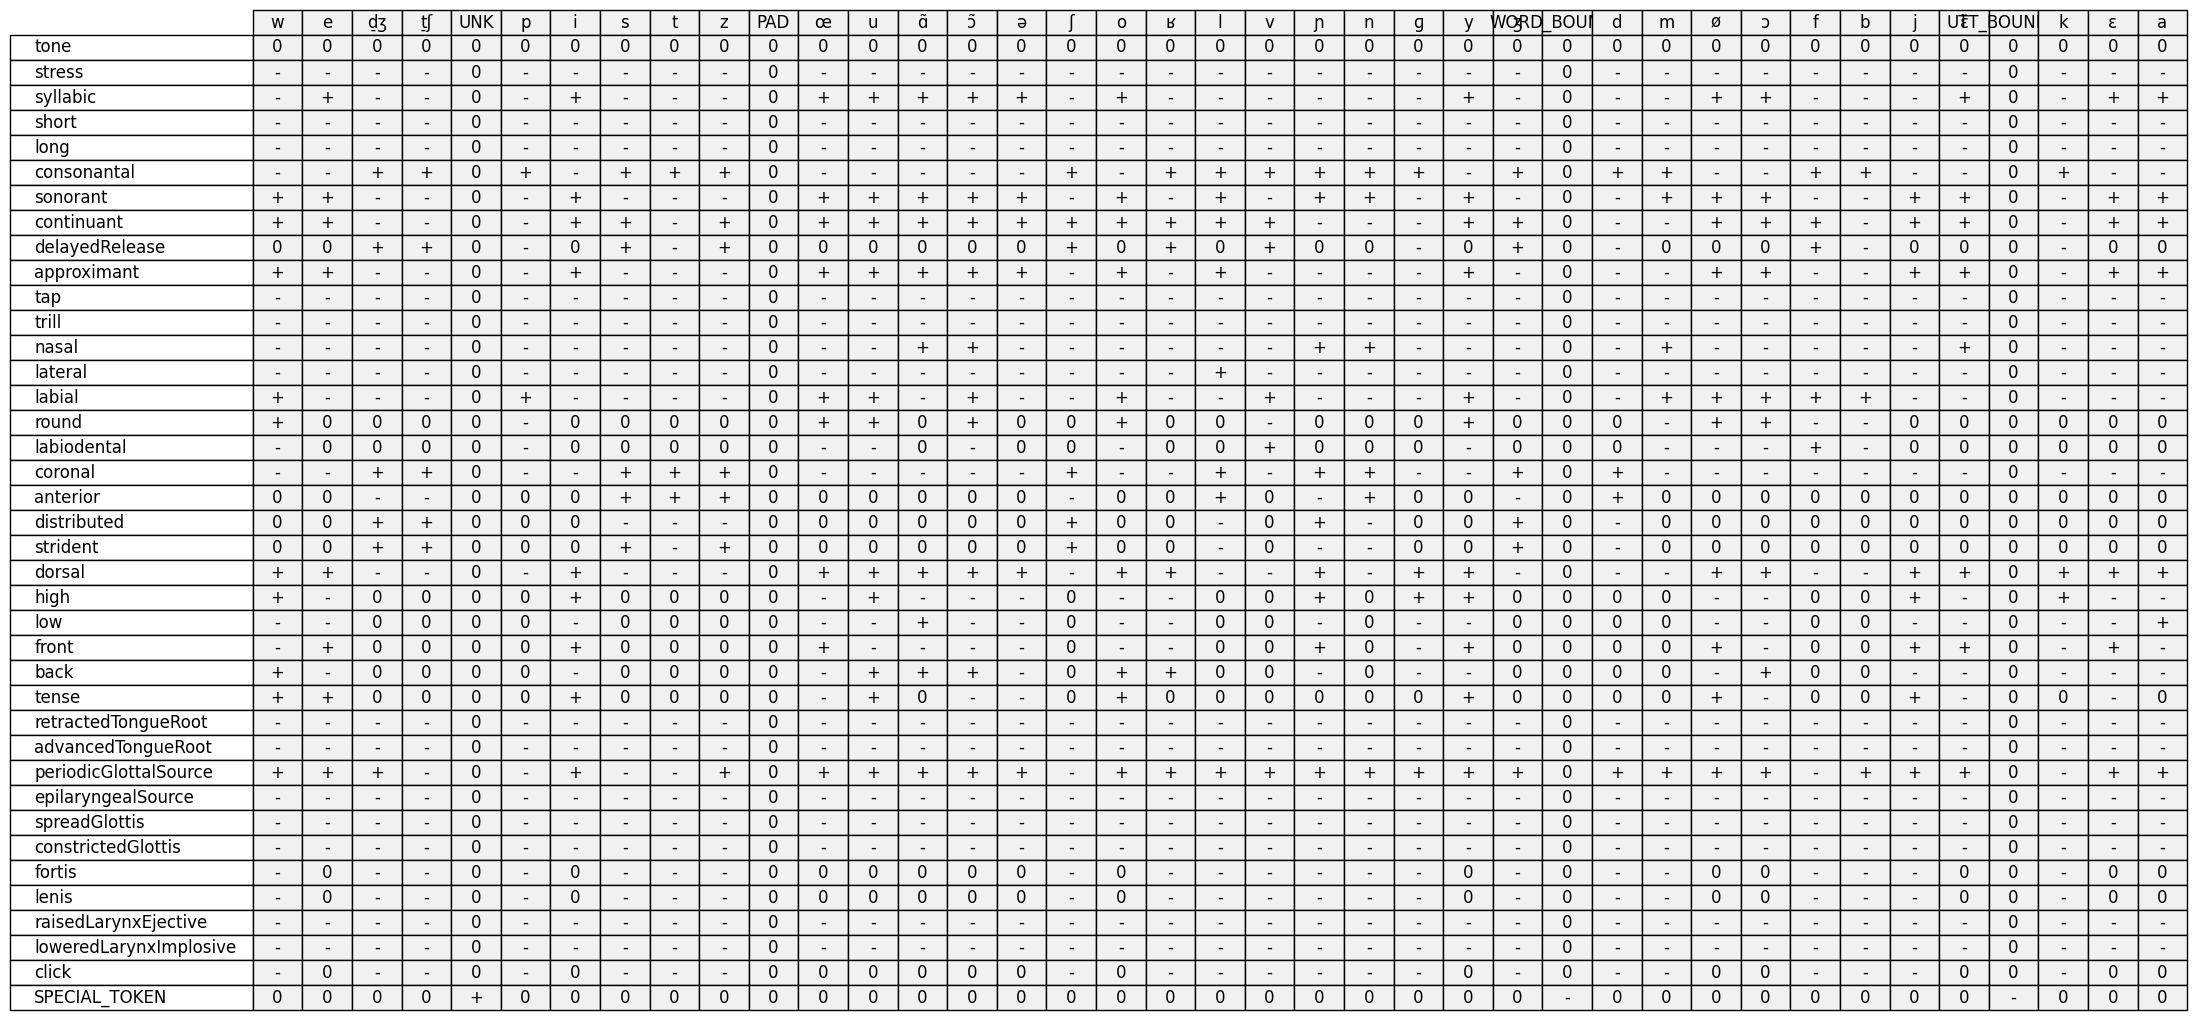

In [10]:
def plot_phoneme_map(language):

    # Create a 2D plot of each element in the phoneme map
    phoneme_map_df = pd.DataFrame(create_phoneme_map(tokenizers[language], '../../data/phoible.csv', convert_to_numeric=False))

    fig, ax = plt.subplots()
    ax.axis('off')  # Turn off the axis

    # Create a table
    colLabels = phoneme_map_df.columns.map(tokenizers[language].convert_ids_to_tokens)
    rowLabels = FEATURES + ['SPECIAL_TOKEN']
    table = ax.table(cellText=phoneme_map_df.values,
                    colLabels=colLabels,
                    cellLoc='center',
                    loc='center',
                    colColours=['#f1f1f1']*len(phoneme_map_df.columns),
                    cellColours=[['#f1f1f1']*len(phoneme_map_df.columns)]*len(phoneme_map_df),
                    colWidths=[0.1]*len(phoneme_map_df.columns), 
                        rowLabels=rowLabels,)

    # Adjust the table properties
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)  # Adjust the scale for better visibility

    # Highlight any values that are not 0, + or -
    for i in range(len(phoneme_map_df)):
        for j in range(len(phoneme_map_df.columns)):
            if phoneme_map_df.iloc[i, j] not in ['0', '+', '-']:
                table[(i+1, j)].set_facecolor('#ff9999')

    plt.show()

plot_phoneme_map('French')

## Load Dataset

In [6]:
def get_tokens_sample(language='English', num_tokens=50000):

    dataset_params = DatasetParams(subconfig=language, name='phonemetransformers/CHILDES', is_phonemes=True, remove_child_utterances=True, text_column='phonemized_utterance')
    data_processing_params = DataPreprocessingParams(max_input_length=64, join_utts=False, remove_word_boundaries=True)
    dataset = setup.load_dataset(dataset_params)
    data_preprocessor = DataPreprocessor(data_processing_params, tokenizers[language], get_word_boundaries=False)
    dataset = dataset.map(data_preprocessor, batched=True, remove_columns=["text"])
    
    dataset = dataset['train'].to_pandas().sample(num_tokens)
    ids = []
    for i, row in dataset.iterrows():
        ids.extend(row['input_ids'])

    return ids[:num_tokens]

def get_dataset_sample(language='English', num_tokens=50000):

    dataset_params = DatasetParams(subconfig=language, name='phonemetransformers/CHILDES', is_phonemes=True, remove_child_utterances=True, text_column='phonemized_utterance')
    data_processing_params = DataPreprocessingParams(max_input_length=64, join_utts=False, remove_word_boundaries=True)
    dataset = setup.load_dataset(dataset_params)
    dataset = dataset['train'].to_pandas()[:num_tokens]
    return dataset



In [7]:
ids = get_tokens_sample()
print(tokenizer.convert_ids_to_tokens(ids[:50]))

['UTT_BOUNDARY', 's', 'ɸ', 't', 'w', 'a', 'o', 'e', 'ts', 'ç', 'k', 'ts', 'UTT_BOUNDARY', 'k', 'ɯ', 'o', 'ɡ', 'd̠ʒ', 't̠ʃ', 'd', 'k', 'o', 'm', 'ɯ', 'ɾ', 'pʲ', 'ç', 'i', 'oː', 'UTT_BOUNDARY', 'ɯː', 'aː', 'ts', 'o', 's', 'e', 'ts', 'UTT_BOUNDARY', 'ɯː', 'aː', 'ts', 'a', 'w', 'bʲ', 'n', 'b', 'n', 'e', None, 'bʲ']


## Get Embeddings

In [8]:
def get_embeddings(language):
    # Get embeddings for each example by feeding in a context of 64 phonemes and using a stride of 16 tokens
    # to ensure every embedding has at least 48 tokens of context

    model = models[language]
    tokenizer = tokenizers[language]
    phoneme_map = phoneme_maps[language]
    ids = get_tokens_sample(language)

    stride = 32
    context_size = 64
    embedding_data = pd.DataFrame(columns=['id', 'ctx_embedding', 'embedding'])
    for i in tqdm(range(0, len(ids)-context_size, stride)):
        input_ids = ids[i:i+context_size]
        attention_mask = [1] * len(input_ids)
        with torch.no_grad():
            final_outputs = model(torch.tensor([input_ids]), attention_mask=torch.tensor([attention_mask]), output_hidden_states=True)
            embedding_outputs = model.get_input_embeddings()(torch.tensor([input_ids]))
            for j in range(len(input_ids) - stride, len(input_ids)):
                idx = input_ids[j]
                ctx_embedding = final_outputs.hidden_states[-1][0][j].numpy() # Final hidden state
                embedding = embedding_outputs[0][j].numpy() # Input embedding
                embedding_data = pd.concat([embedding_data, pd.DataFrame({'id': idx, 'ctx_embedding': [ctx_embedding], 'embedding': [embedding]})])

    for i, feature in enumerate(FEATURES):
        embedding_data[feature] = embedding_data['id'].apply(lambda x: phoneme_map[x][i])

    # Drop UTT_BOUNDARY, WORD_BOUNDARY, PAD and UNK tokens
    special_tokens = ['UTT_BOUNDARY', 'WORD_BOUNDARY', 'PAD', 'UNK']
    special_tokens = tokenizer.convert_tokens_to_ids(special_tokens)
    embedding_data = embedding_data[~embedding_data['id'].isin(special_tokens)]

    # Remove tokens that occur less than 10 times
    rare_tokens = embedding_data['id'].value_counts()[embedding_data['id'].value_counts() < 10].index
    print('Rare tokens:', tokenizer.convert_ids_to_tokens(rare_tokens))
    embedding_data = embedding_data[~embedding_data['id'].isin(rare_tokens)]

    return embedding_data


In [9]:
if os.path.exists('embedding_data.pkl'):
    embedding_data = pd.read_pickle('embedding_data.pkl')
else:
    embedding_data = {language : get_embeddings(language) for language in models.keys()}
    pd.to_pickle(embedding_data, 'embedding_data.pkl')

In [10]:
def get_distinguishing_features(language):
    # Get all features for which there are at least 4 phonemes in the phoneme map that exhibit the feature
    # and at least 4 phonemes that do not exhibit the feature. Ensure also that the phonemes occur at least 10 times
    # in the dataset
    distinguishing_features = []
    phoneme_map_df = pd.DataFrame(phoneme_maps[language]).T
    for i, feature in enumerate(FEATURES):
        pos_ids = phoneme_map_df[phoneme_map_df[i] == 2].index
        neg_ids = phoneme_map_df[phoneme_map_df[i] == 1].index

        id_freqs = embedding_data[language]['id'].value_counts()
        pos_ids = [idx for idx in pos_ids if idx in id_freqs and id_freqs[idx] >= 10]
        neg_ids = [idx for idx in neg_ids if idx in id_freqs and id_freqs[idx] >= 10]
        
        if len(pos_ids) >= 4 and len(neg_ids) >= 4:
            distinguishing_features.append(feature)

    return distinguishing_features

## Predict Features


In [11]:
# Train a linear model to predict the syllabic feature from the embeddings
def predict_feature(embedding_data, feature, embedding_vector='ctx_embedding', plot=False, micro_average=False):

    logo = LeaveOneGroupOut()

    # Make a copy of the embedding data
    feature_data = embedding_data.copy()[['id', embedding_vector, feature]]
    feature_data = feature_data[feature_data[feature] != 0]
    feature_data[feature] -= 1  # Convert to 0-indexed

    groups = feature_data['id'].values

    X = np.array(feature_data[embedding_vector].tolist())
    y = np.array(feature_data[feature].tolist())

    assert len(set(y)) == 2

    test_ids = []
    feature_value = []
    count = []
    accuracies = []

    for train_index, test_index in logo.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        if len(y_test) < 10:
            print('Skipping test set with less than 10 examples for feature', feature, 'and token', groups[test_index[0]])
            continue

        test_ids.append(groups[test_index[0]])
        feature_value.append(y_test[0])
        count.append(len(y_test))

        # Balance X_train and y_train to ensure equal representation of each class
        min_class = min(np.sum(y_train == 0), np.sum(y_train == 1))
        if min_class == 0:
            print('Skipping test set with only one class for feature', feature, 'and token', groups[test_index[0]])
            continue

        X_train = np.concatenate([X_train[y_train == 0][:min_class], X_train[y_train == 1][:min_class]])
        y_train = np.concatenate([y_train[y_train == 0][:min_class], y_train[y_train == 1][:min_class]])

        clf = LogisticRegression(max_iter=1000)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        accuracies.append(accuracy_score(y_test, y_pred))

    if plot:
        accuracy_df = pd.DataFrame({'id': test_ids, 'accuracy': accuracies})
        xlabels = tokenizer.convert_ids_to_tokens(accuracy_df['id'].values)
        accuracy_df['feature'] = accuracy_df['id'].apply(lambda x: '+' if phoneme_map[x][FEATURES.index(feature)] == 2 else '-')

        plt.figure(figsize=(10, 6))
        plt.axhline(0.5, color='grey', linestyle='--')
        sns.barplot(x='id', y='accuracy', data=accuracy_df, hue='feature', dodge=False)
        plt.xticks(range(len(xlabels)), xlabels, rotation=90)
        plt.xlabel('Phoneme')
        plt.ylabel('Accuracy')
        plt.title(f'Accuracy of predicting {feature} feature from GPT-2 embeddings')
        plt.legend(title=feature)
        plt.show()

    # Get micro average accuracy
    if micro_average:
        return np.average(accuracies, weights=count)

    return accuracies

In [12]:
distinguishing_features = {language : get_distinguishing_features(language) for language in models.keys()}
overlapping_features = set(distinguishing_features['English'])
for language, features in distinguishing_features.items():
    overlapping_features = overlapping_features.intersection(set(features))
print('Overlapping distinguishing features:', overlapping_features)

Overlapping distinguishing features: {'consonantal', 'syllabic', 'dorsal', 'approximant', 'continuant', 'periodicGlottalSource', 'sonorant', 'coronal', 'delayedRelease', 'labial'}


In [14]:
# Try to load the accuracies from a csv
if os.path.exists('feature_prediction_accuracies.csv'):
    feature_prediction_accuracies = pd.read_csv('feature_prediction_accuracies.csv')
    feature_prediction_accuracies['accuracy'] = feature_prediction_accuracies['accuracy'].apply(lambda x: np.array(x.strip('[]').split(','), dtype=float))
else:
    feature_prediction_accuracies = pd.DataFrame(columns=['language', 'feature', 'accuracy'])
    for language, data in embedding_data.items():
        for feature in overlapping_features:
            print('Predicting feature', feature, 'for language', language)
            accuracies = predict_feature(data, feature, embedding_vector='ctx_embedding', micro_average=False)
            feature_prediction_accuracies = pd.concat([feature_prediction_accuracies, pd.DataFrame({'language': [language], 'feature': [feature], 'accuracy': [accuracies]})])
    feature_prediction_accuracies.to_csv('feature_prediction_accuracies.csv', index=False)

In [15]:
# For each list of accuracies, check the probability that it was sampled from a bionomial distribution with p=0.5
from scipy.stats import binom_test
# Convert string to array of floats
# Convert series to list of floats
feature_prediction_accuracies['p_value'] = feature_prediction_accuracies['accuracy'].apply(lambda x: binom_test(np.sum(x), n=len(x), p=0.5, alternative='greater'))

In [16]:
feature_prediction_accuracies

,language,feature,accuracy,p_value
0,Spanish,syllabic,"[0.6817788045047647, 0.5401188707280832, 0.898...",0.000018
1,Spanish,coronal,"[0.5238232746173838, 0.9925705794947994, 0.864...",0.075795
2,Spanish,periodicGlottalSource,"[0.8813167773606699, 0.962481426448737, 0.9492...",0.580590
3,Spanish,delayedRelease,"[0.7610264635124299, 0.28476664297559817, 0.79...",0.725586
4,Spanish,continuant,"[0.6666185388391568, 0.9777117384843982, 0.764...",0.419410
...,...,...,...,...
105,Japanese,consonantal,"[1.0, 1.0, 0.9359550561797753, 0.9955555555555...",0.000439
106,Japanese,dorsal,"[0.0, 1.0, 0.9640449438202248, 0.44, 0.9204018...",0.100244
107,Japanese,sonorant,"[0.6595744680851063, 1.0, 0.9912359550561798, ...",0.014725
108,Japanese,labial,"[0.9787234042553191, 1.0, 0.000449438202247191...",0.074806


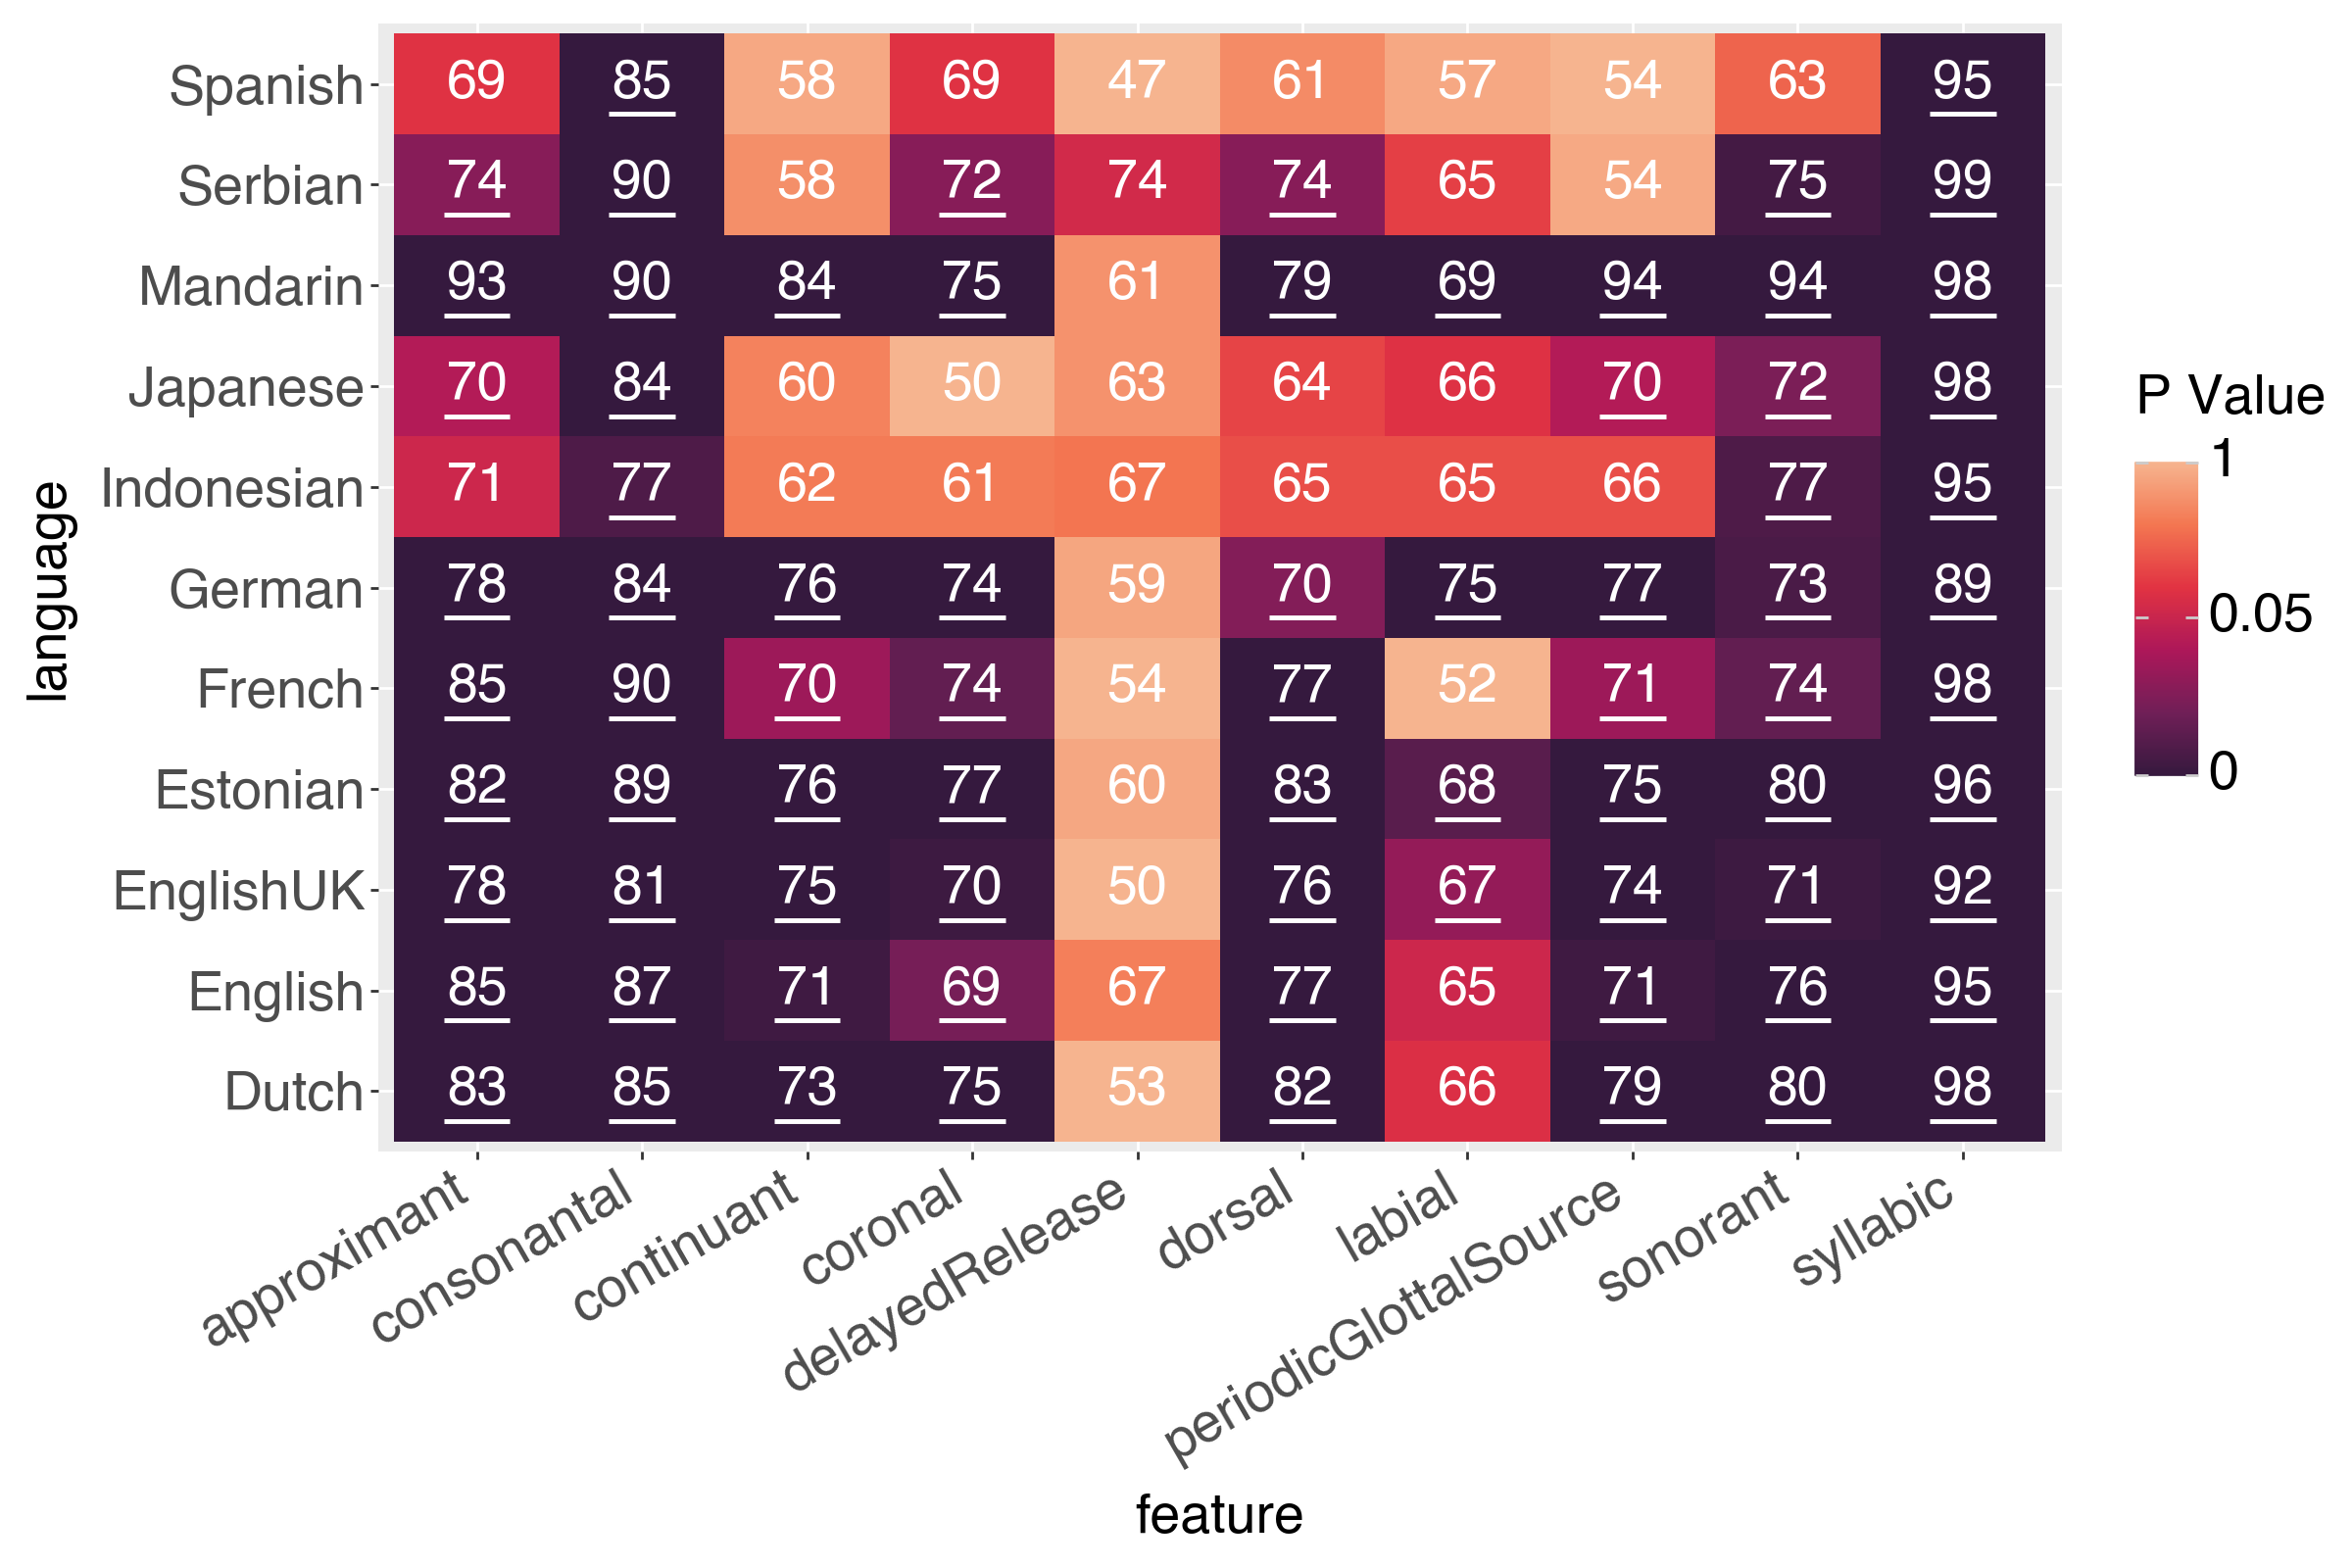

In [43]:
def plot_feature_accuracies(language='English'):
    # Plot 
    feature_df = feature_prediction_accuracies[feature_prediction_accuracies['language'] == language]
    feature_df = feature_df.sort_values('accuracy', ascending=False)
    feature_df['accuracy'] = feature_df['accuracy'] * 100

    plt.figure(figsize=(10, 6))
    sns.barplot(x='feature', y='accuracy', data=feature_df)
    plt.xticks(rotation=45)
    plt.xlabel('Feature')
    plt.ylabel('Accuracy')
    plt.title('Accuracy of predicting phonological features from GPT-2 embeddings')
    plt.show()

def plot_all_feature_accuracies(feature_prediction_accuracies):

    plt_data = feature_prediction_accuracies.copy()
    plt_data['accuracy'] = plt_data['accuracy'].apply(lambda x: np.average(x))
    plt_data['accuracy'] = plt_data['accuracy'] * 100
    # Add star if p_value is significant
    #plt_data['accuracy_label'] = plt_data.apply(lambda x: f"{x['accuracy']:.0f}{'*' if x['p_value'] < 0.05 else ''}", axis=1)

    fnt_size = 20

    # Draw a heatmap with plotnine
    p = (p9.ggplot(plt_data,p9.aes(x='feature', y='language', fill='p_value'))
        + p9.geom_tile()
        + p9.theme(axis_text_x=p9.element_text(rotation=30, hjust=1, size=fnt_size),
                   axis_text_y=p9.element_text(size=fnt_size),
                     axis_title=p9.element_text(size=fnt_size),
                     # Set legend title to "significance" with font size fnt_size
                        legend_title=p9.element_text(text='P Value', size=fnt_size),
                        legend_text=p9.element_text(size=fnt_size),
                        legend_position='right',
                        figure_size=(12, 8))
        # Scale from 0 to 1 using log scale so that 0.05 is in the middle
        # Log scale
        #+  p9.scale_fill_gradientn(colors=sns.color_palette('rocket'), limits=[0.001, 1], breaks=[0.001, 0.05, 1], labels=['0.001', '0.05', '1'])
        + p9.scale_fill_gradientn(colors=sns.color_palette('rocket'), trans='log', limits=[0.005, 0.5], breaks=[0.005, 0.05, 0.5], labels=['0', '0.05', '1'])
        # Add accuracy into grid, append 
        + p9.geom_text(p9.aes(label='accuracy'), size=fnt_size, color='white', ha='center', va='center', format_string='{:.0f}')


    )

    # Replace 0.05 with ">0.05" in the legend
    #p += p9.scale_fill_gradientn(guide=p9.guide_colorbar(title='P Value', ticks=[0, 0.05], labels=['0', '>0.05']))

    features = plt_data['feature'].unique()
    features.sort()
    languages = plt_data['language'].unique()
    languages.sort()

    # Underline if the p-value is significant
    for i, row in plt_data.iterrows():
        if row['p_value'] < 0.05:
            # Add a thin line under the text
            # Get tile x and y
            x = features.tolist().index(row['feature'])+1
            y = languages.tolist().index(row['language'])+1 - 0.3
            p += p9.annotate('segment', x=x-0.2, xend=x+0.2, y=y, yend=y, color='white', size=1)

    p.show()
    

plot_all_feature_accuracies(feature_prediction_accuracies=feature_prediction_accuracies)


Spanish


100%|██████████| 24/24 [00:00<00:00, 374.46it/s]


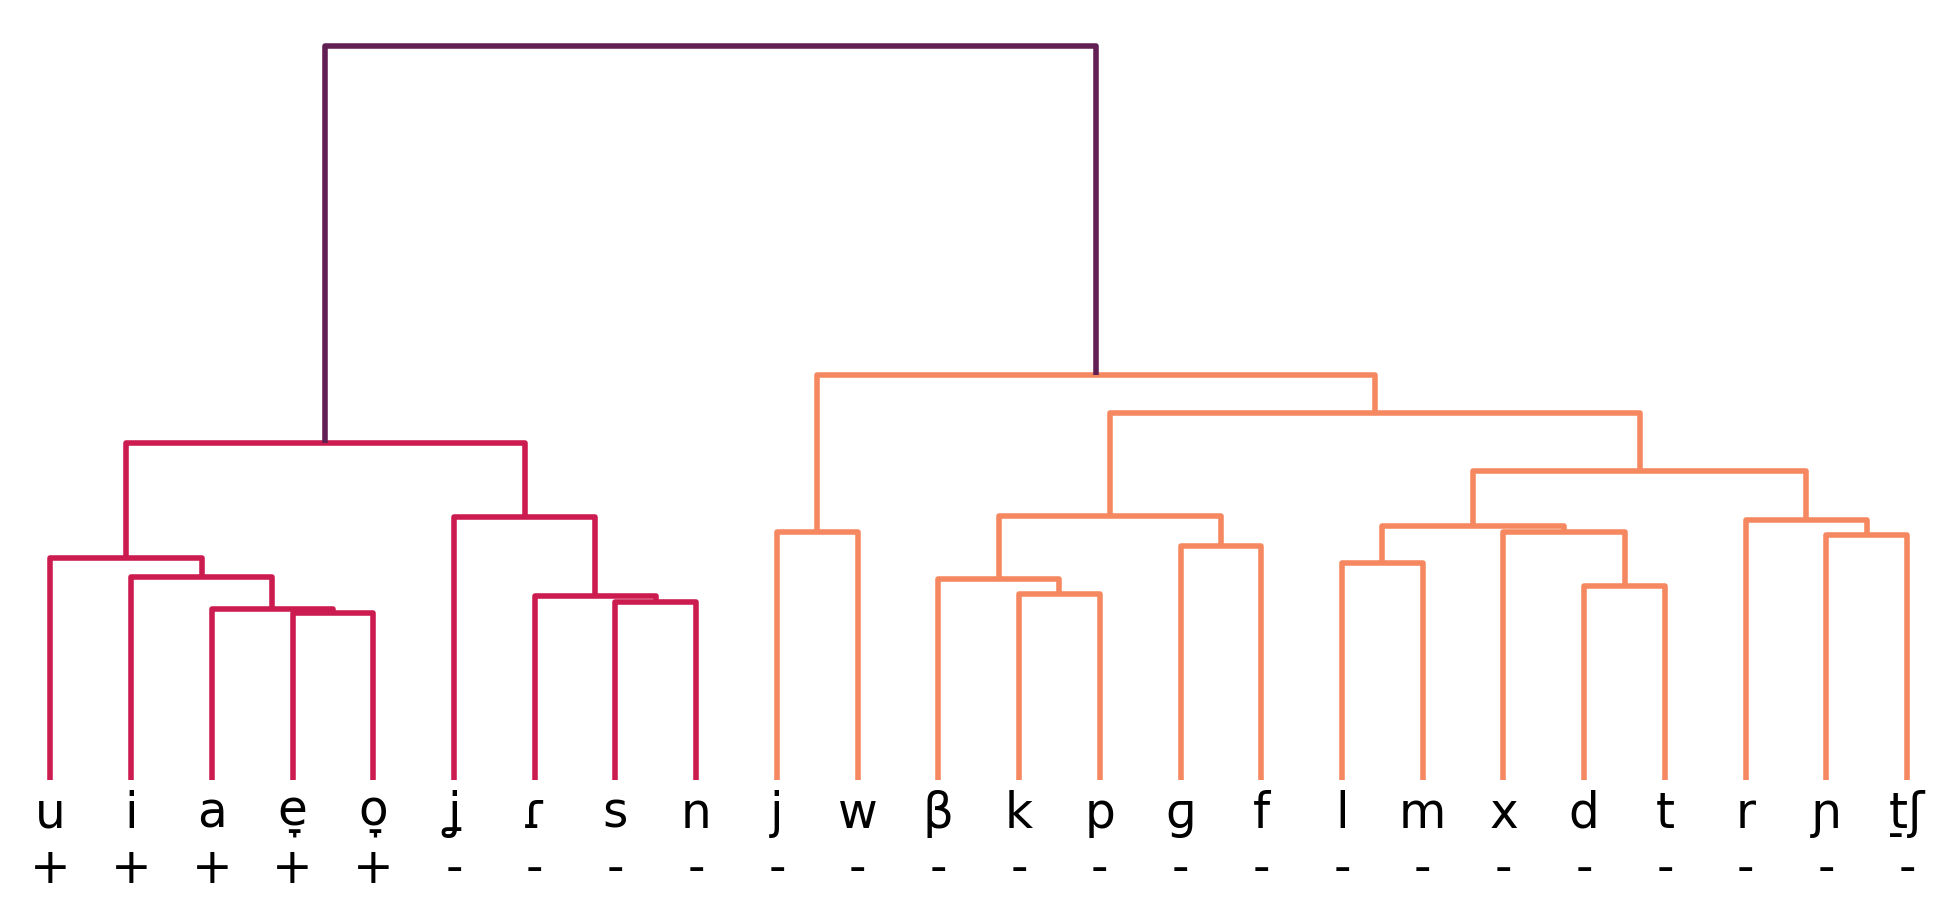

French


100%|██████████| 32/32 [00:00<00:00, 392.24it/s]


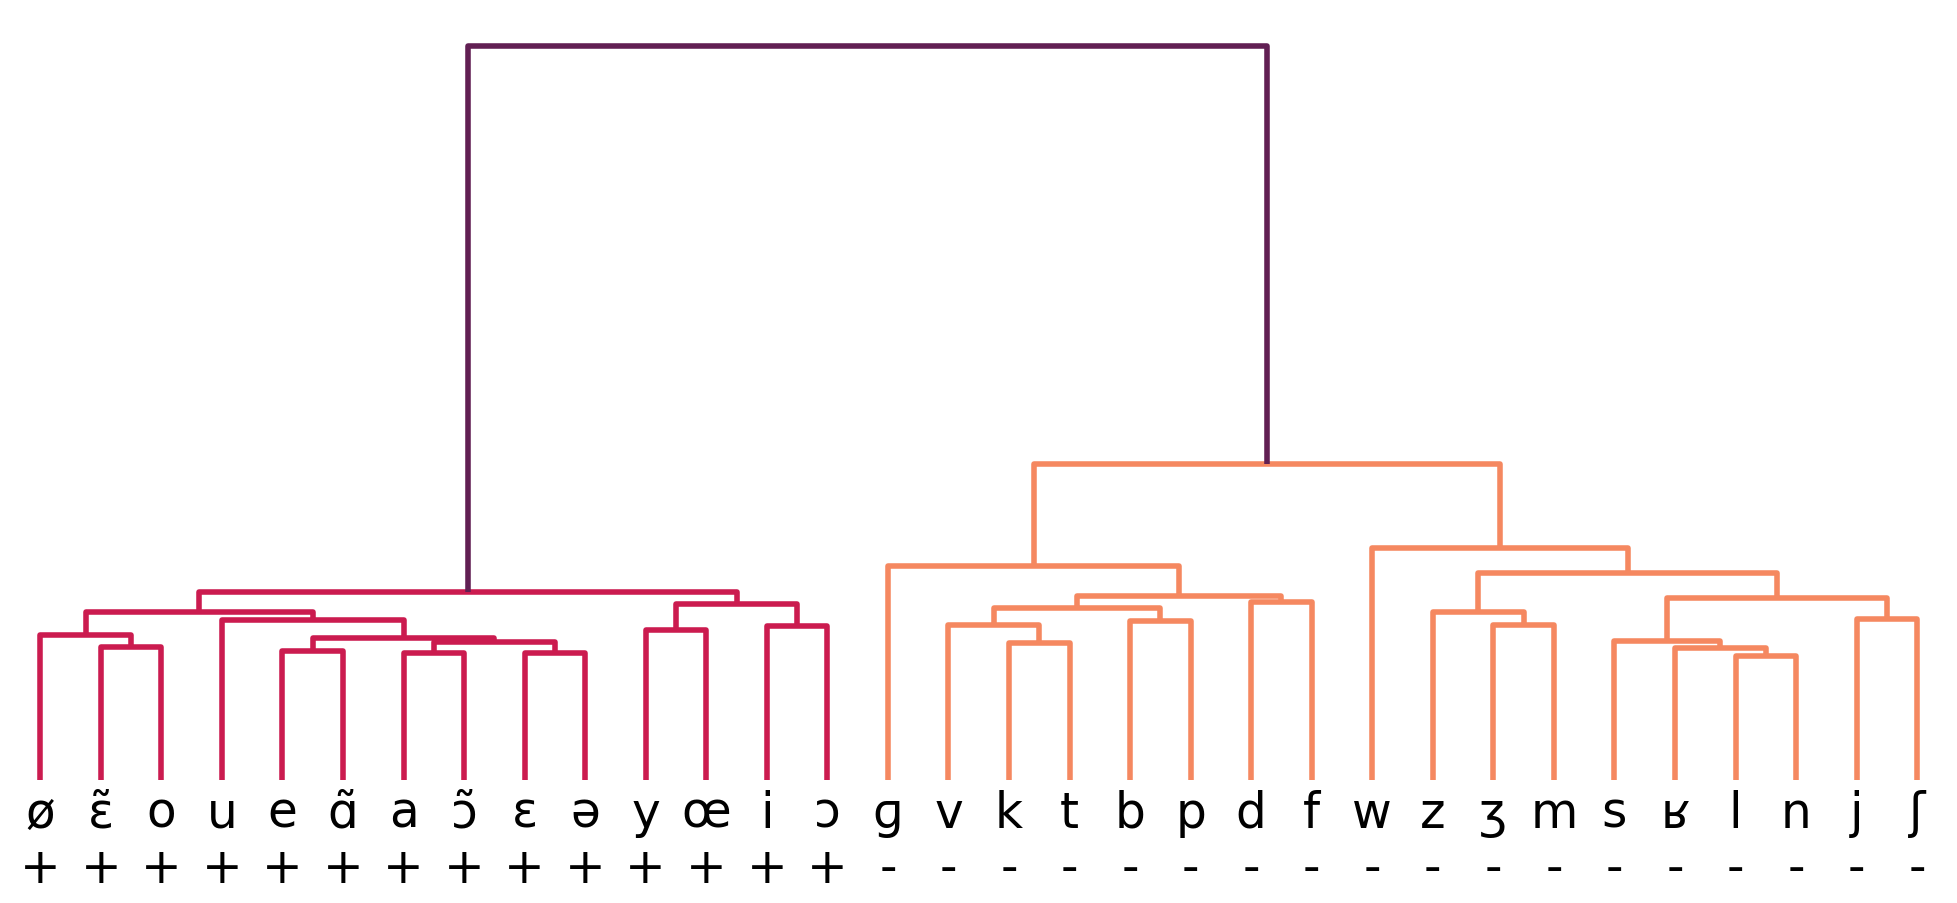

Dutch


100%|██████████| 39/39 [00:00<00:00, 427.16it/s]


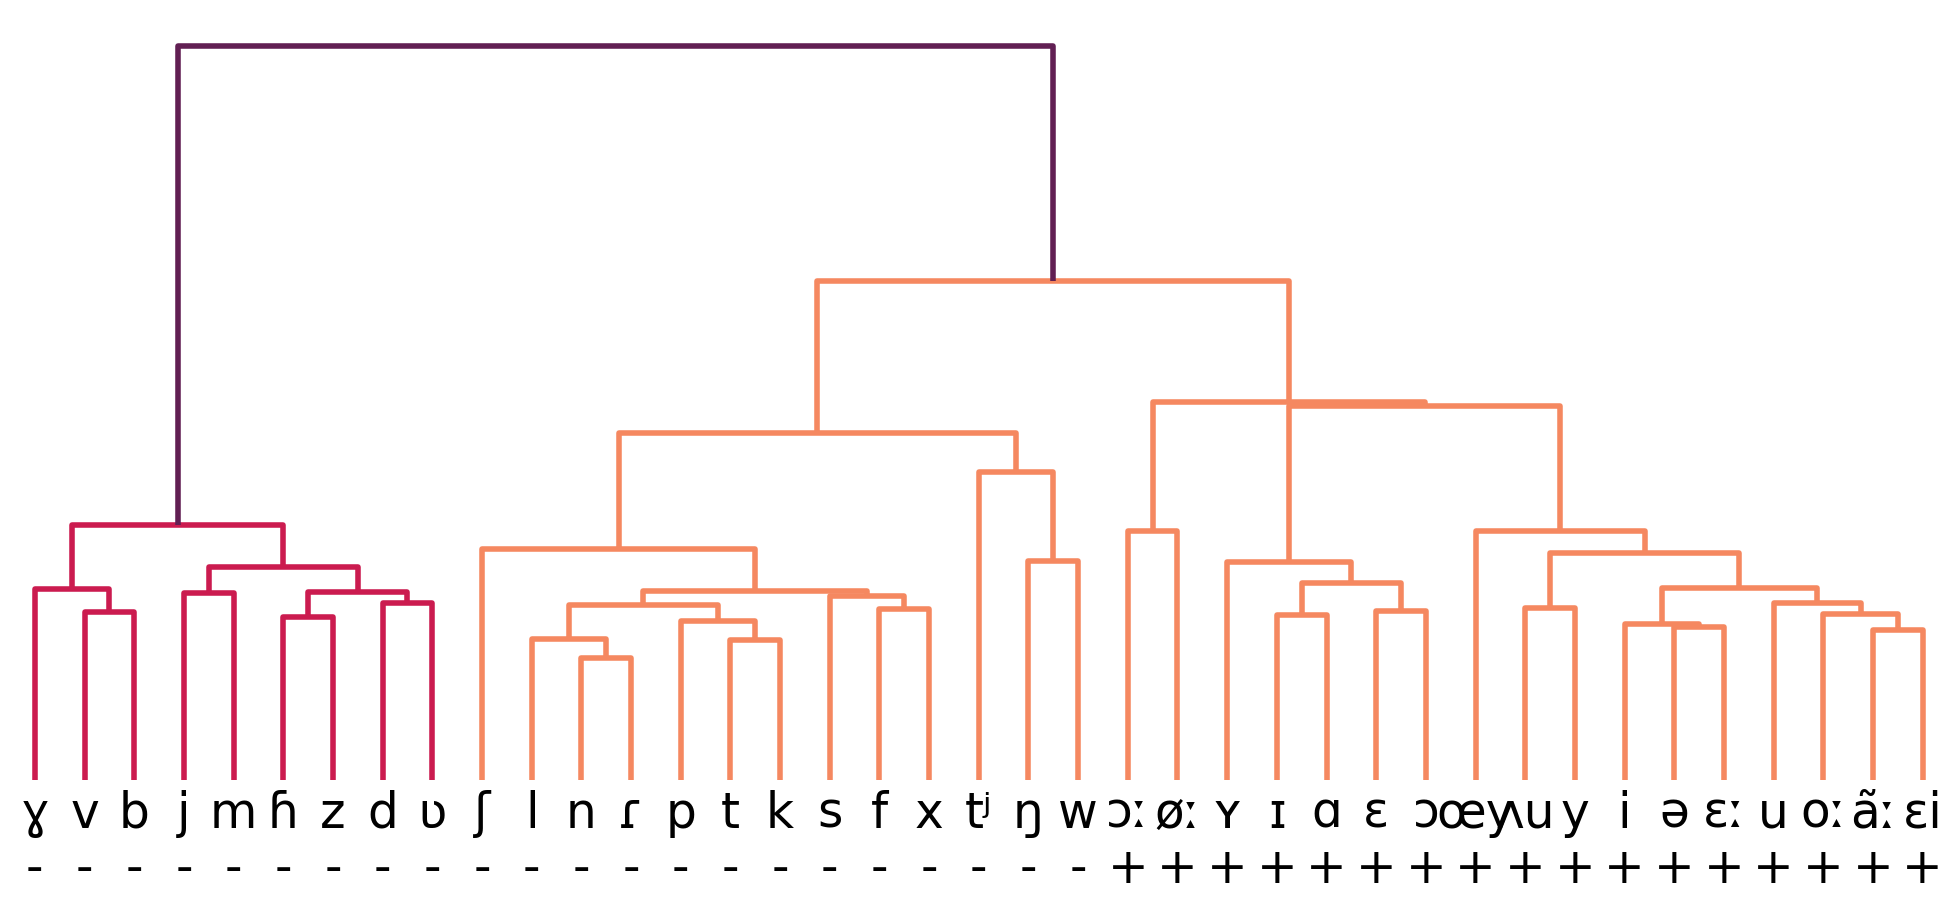

Mandarin


100%|██████████| 98/98 [00:00<00:00, 478.40it/s]


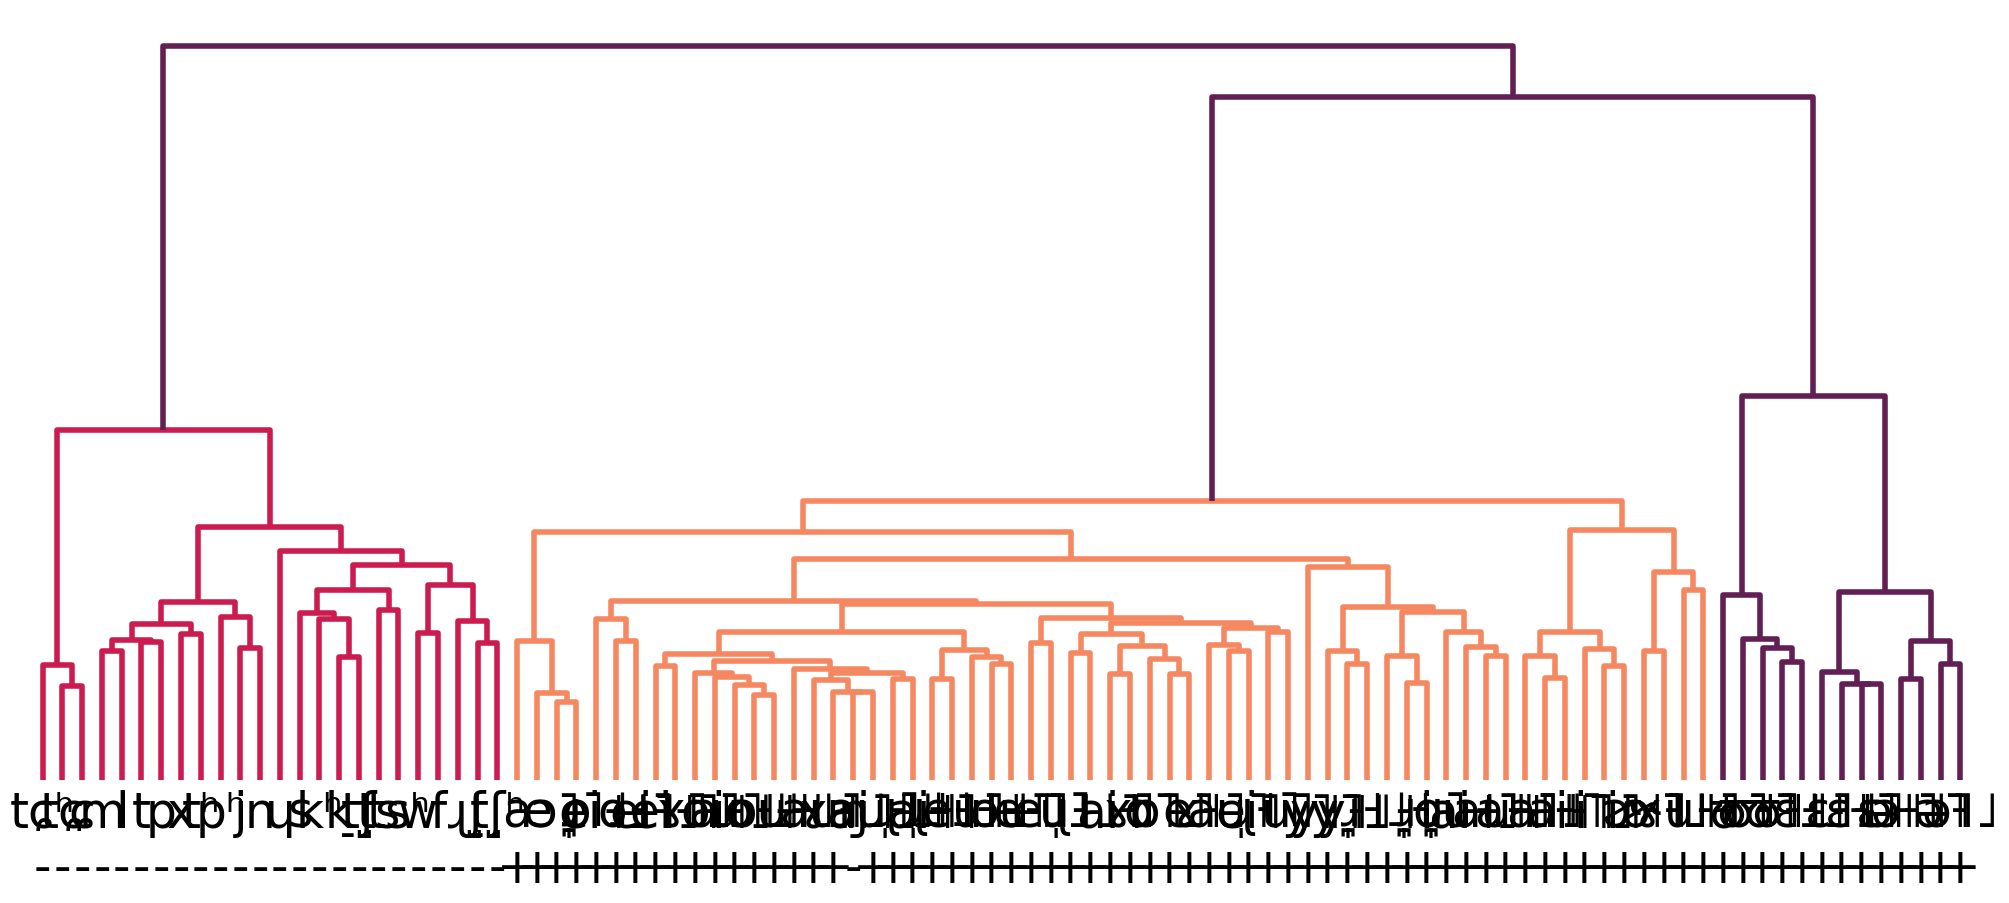

Serbian


100%|██████████| 28/28 [00:00<00:00, 248.45it/s]


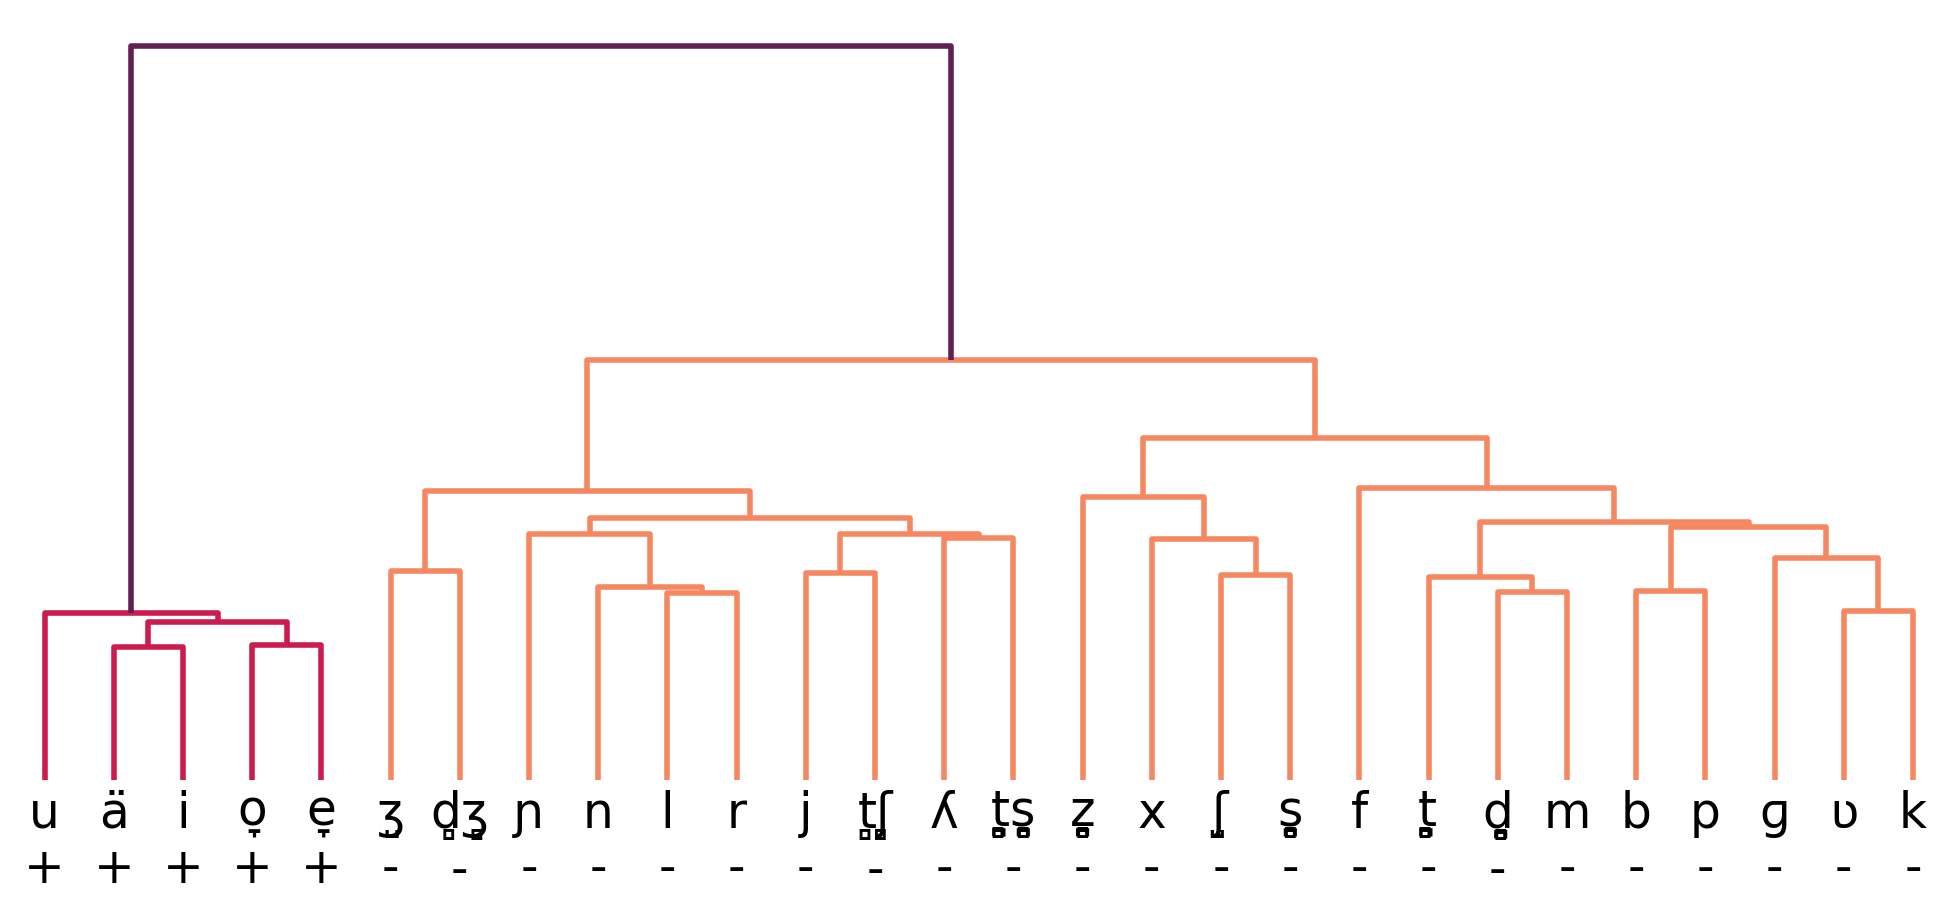

Estonian


100%|██████████| 52/52 [00:00<00:00, 441.06it/s]


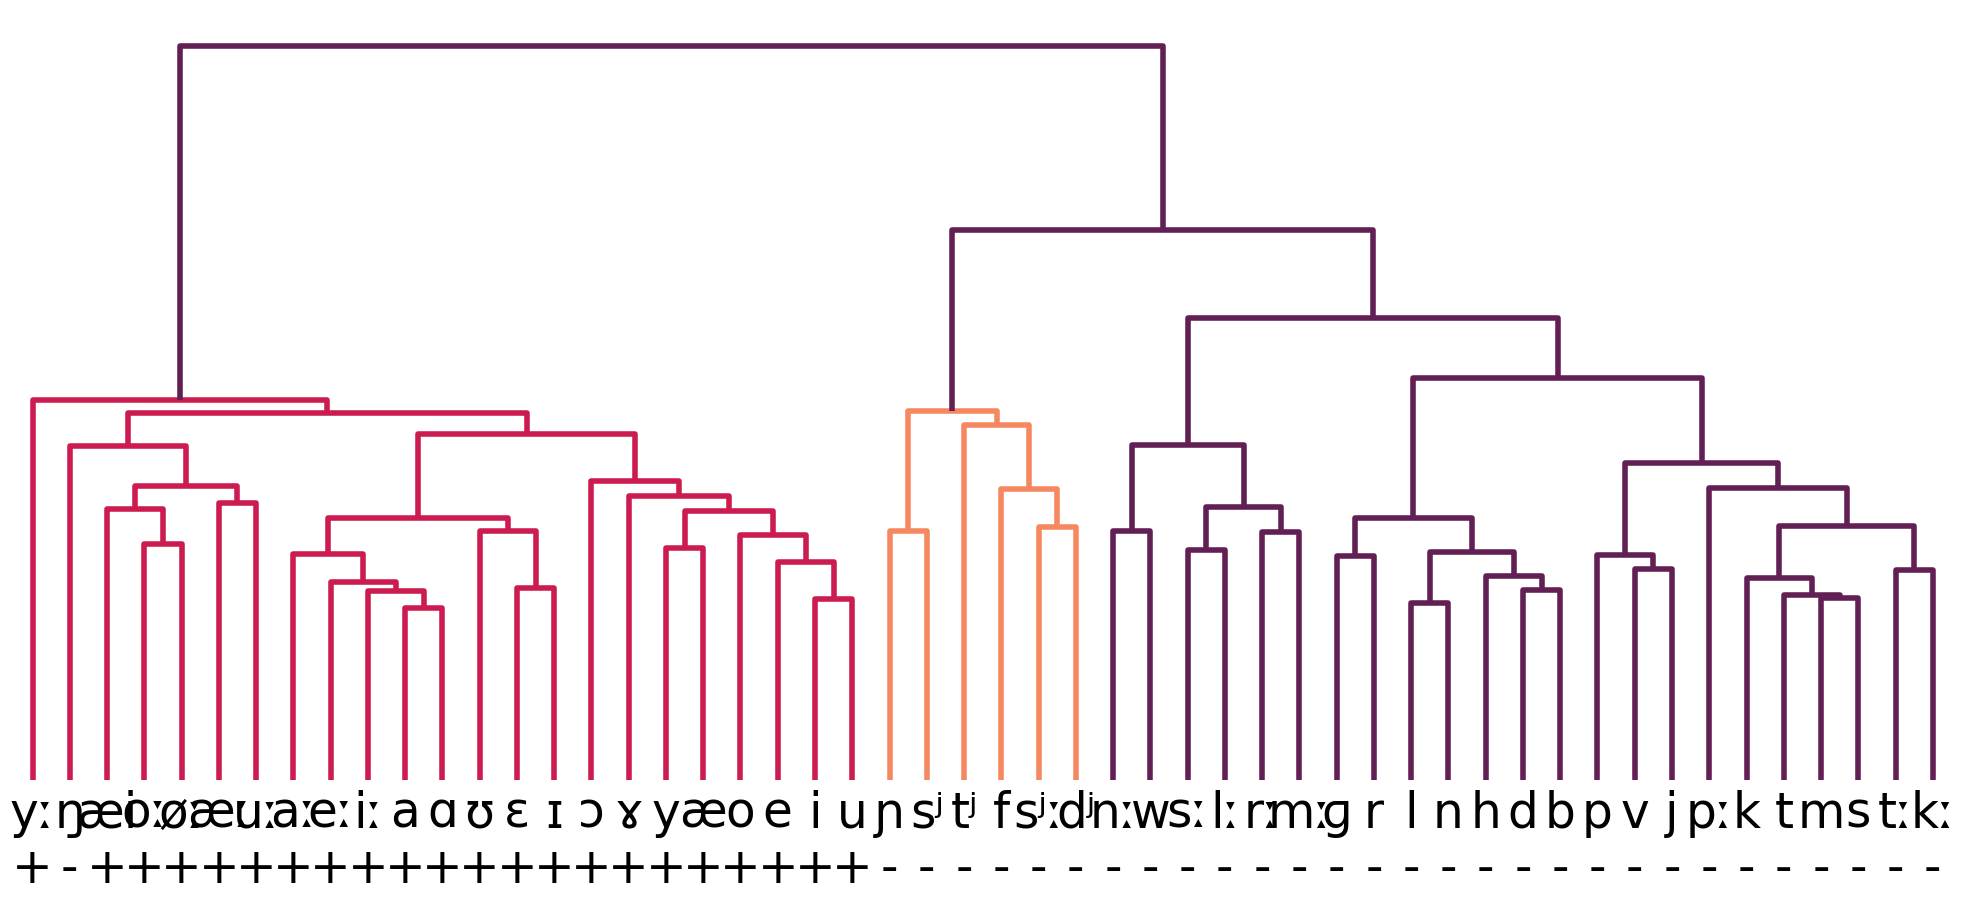

English


100%|██████████| 41/41 [00:00<00:00, 428.81it/s]


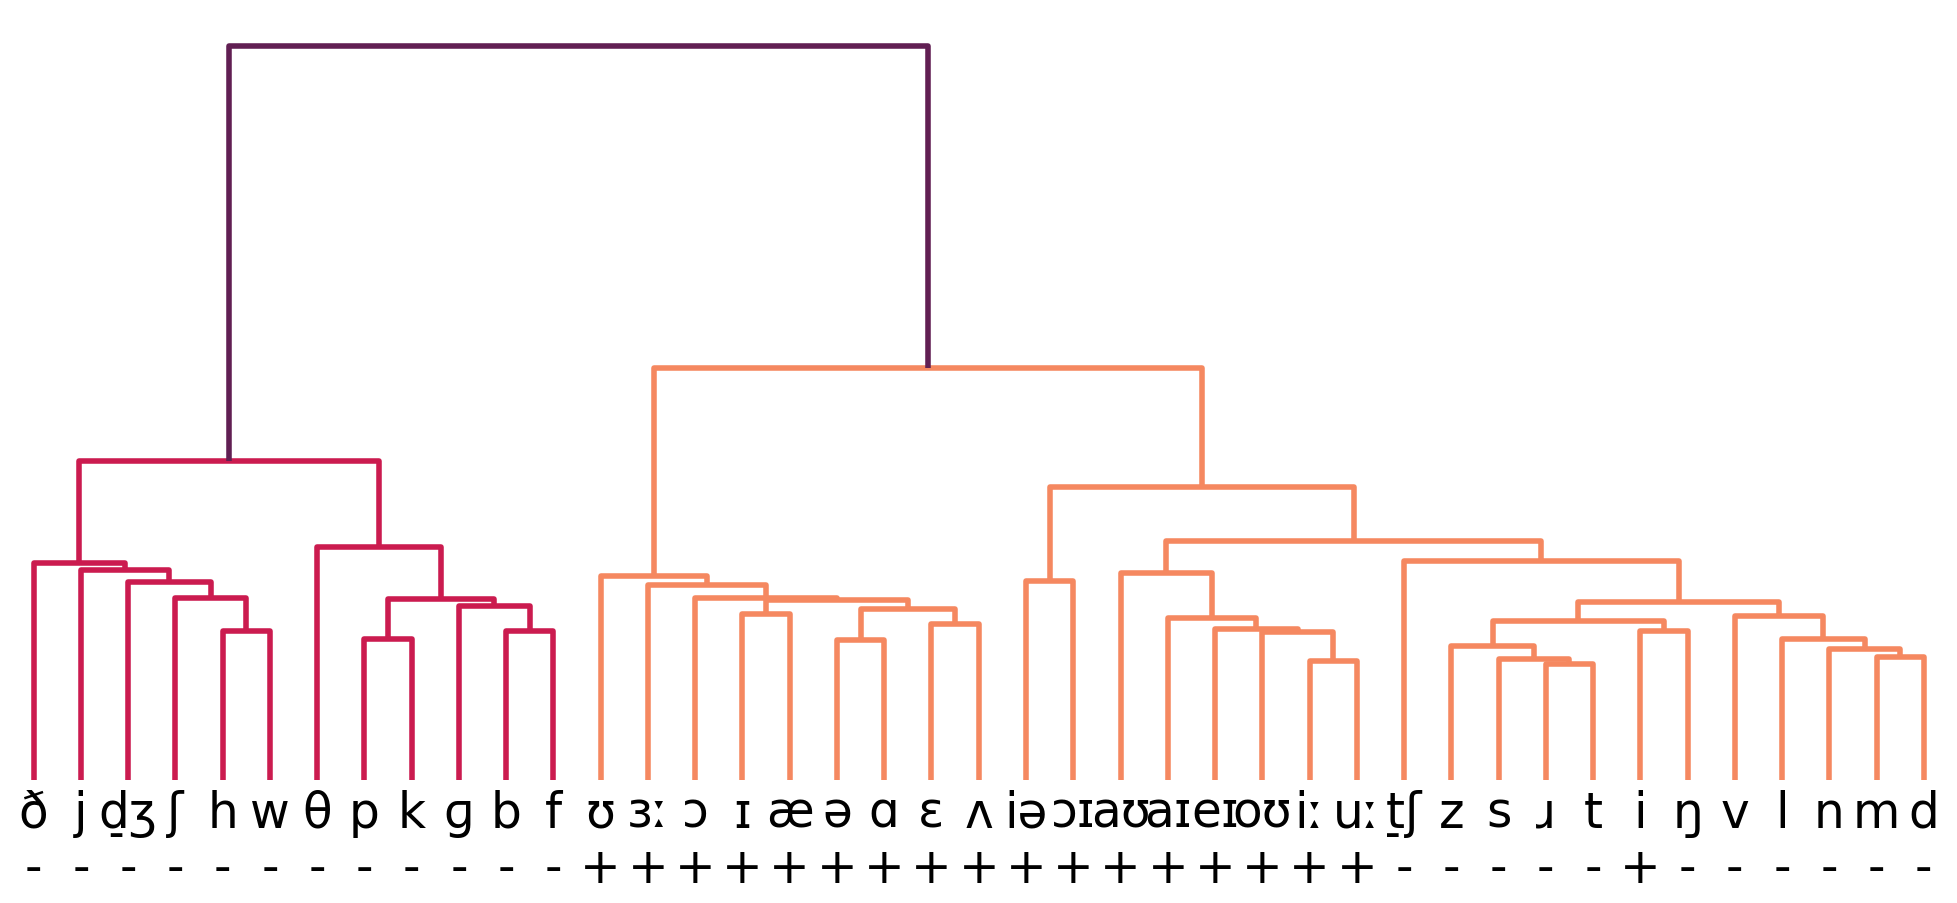

German


100%|██████████| 38/38 [00:00<00:00, 425.61it/s]


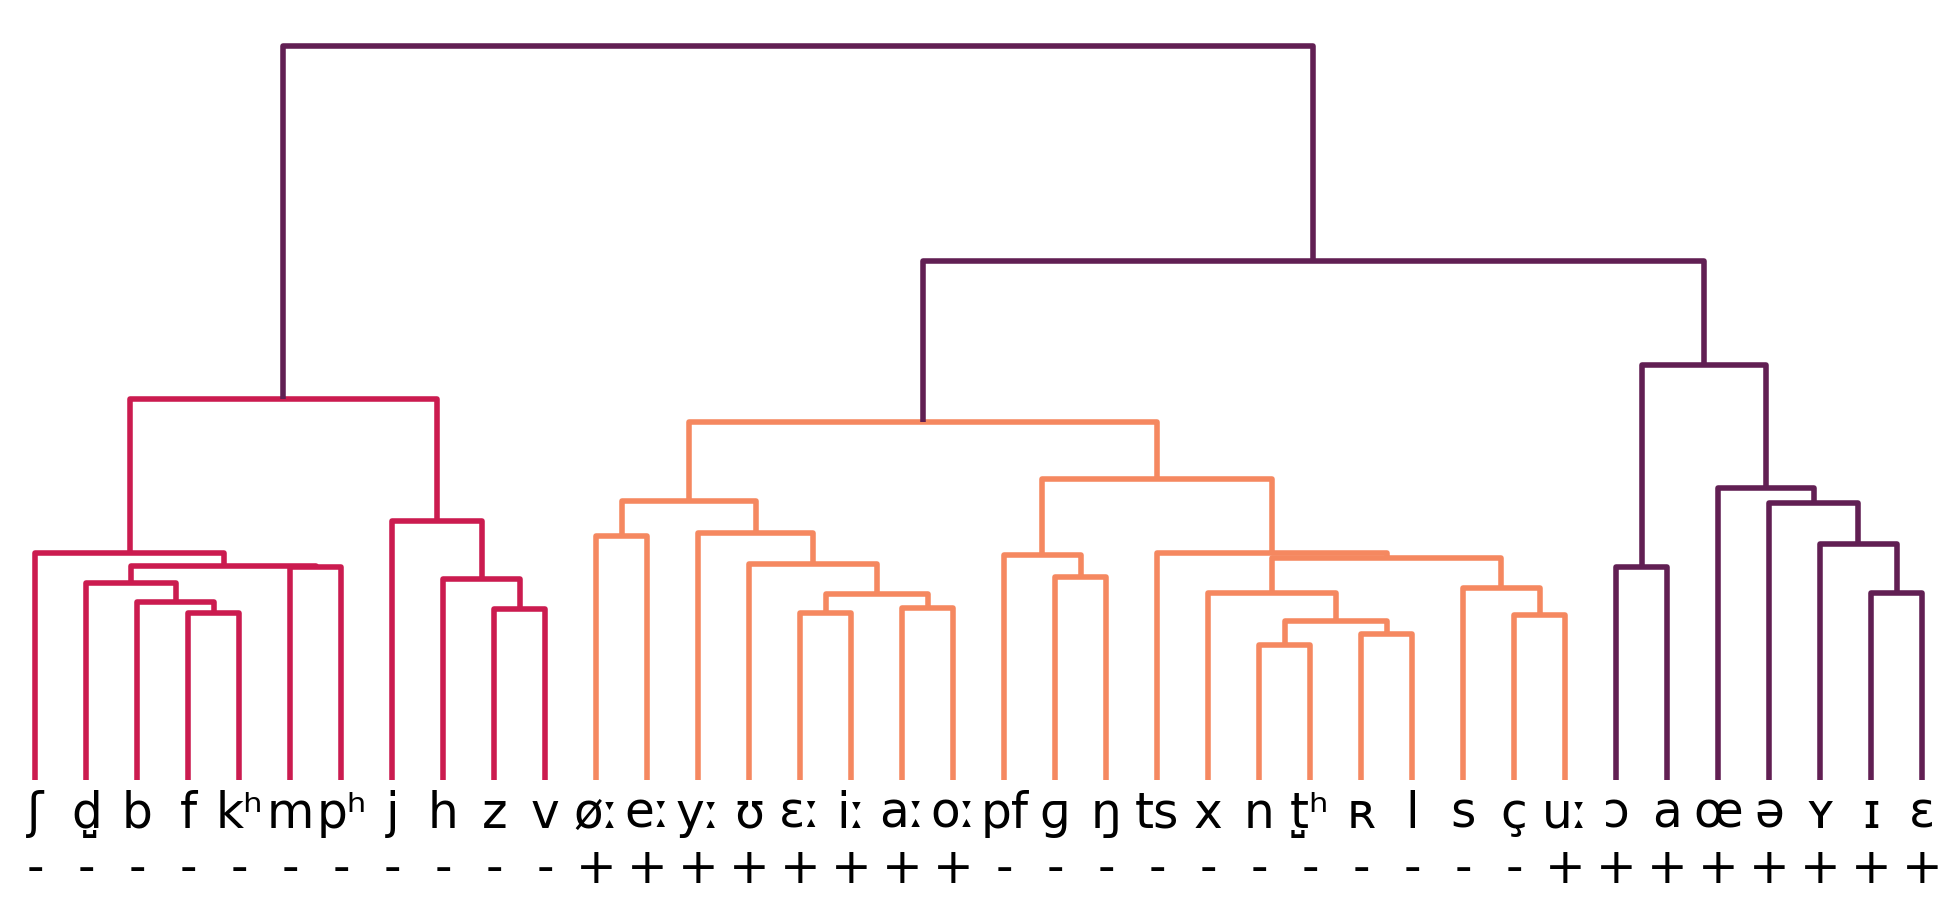

EnglishUK


100%|██████████| 46/46 [00:00<00:00, 432.93it/s]


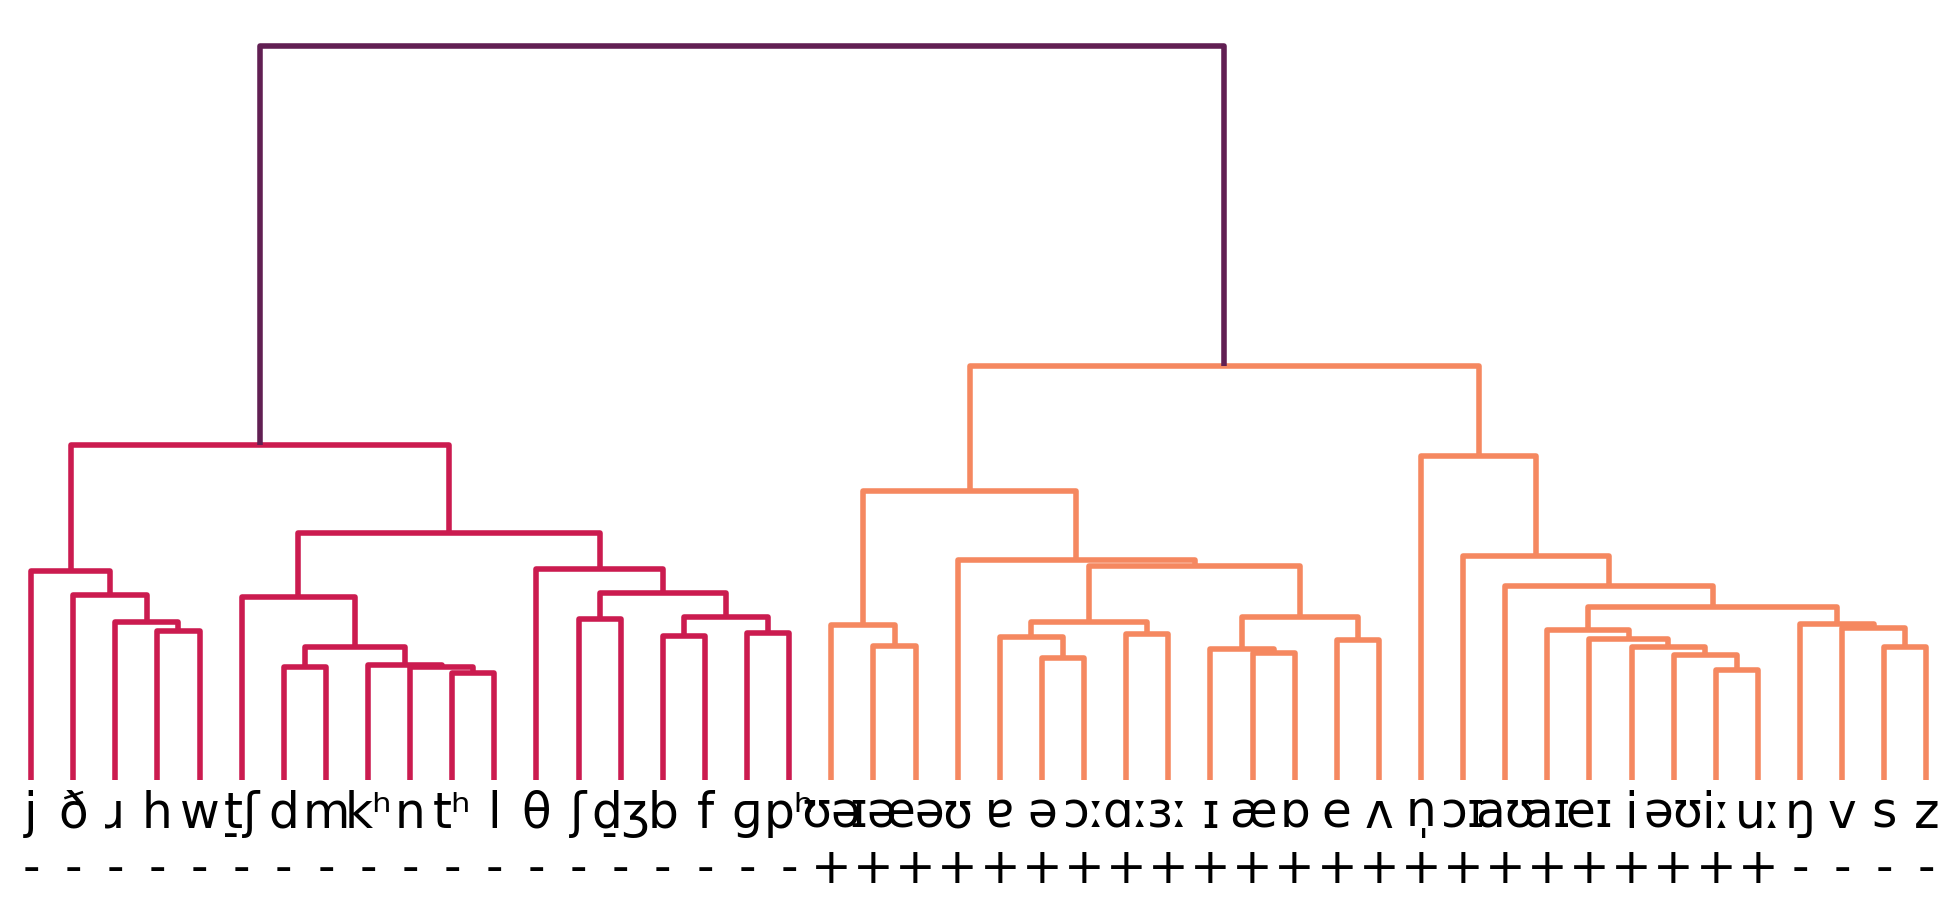

Indonesian


100%|██████████| 25/25 [00:00<00:00, 392.90it/s]


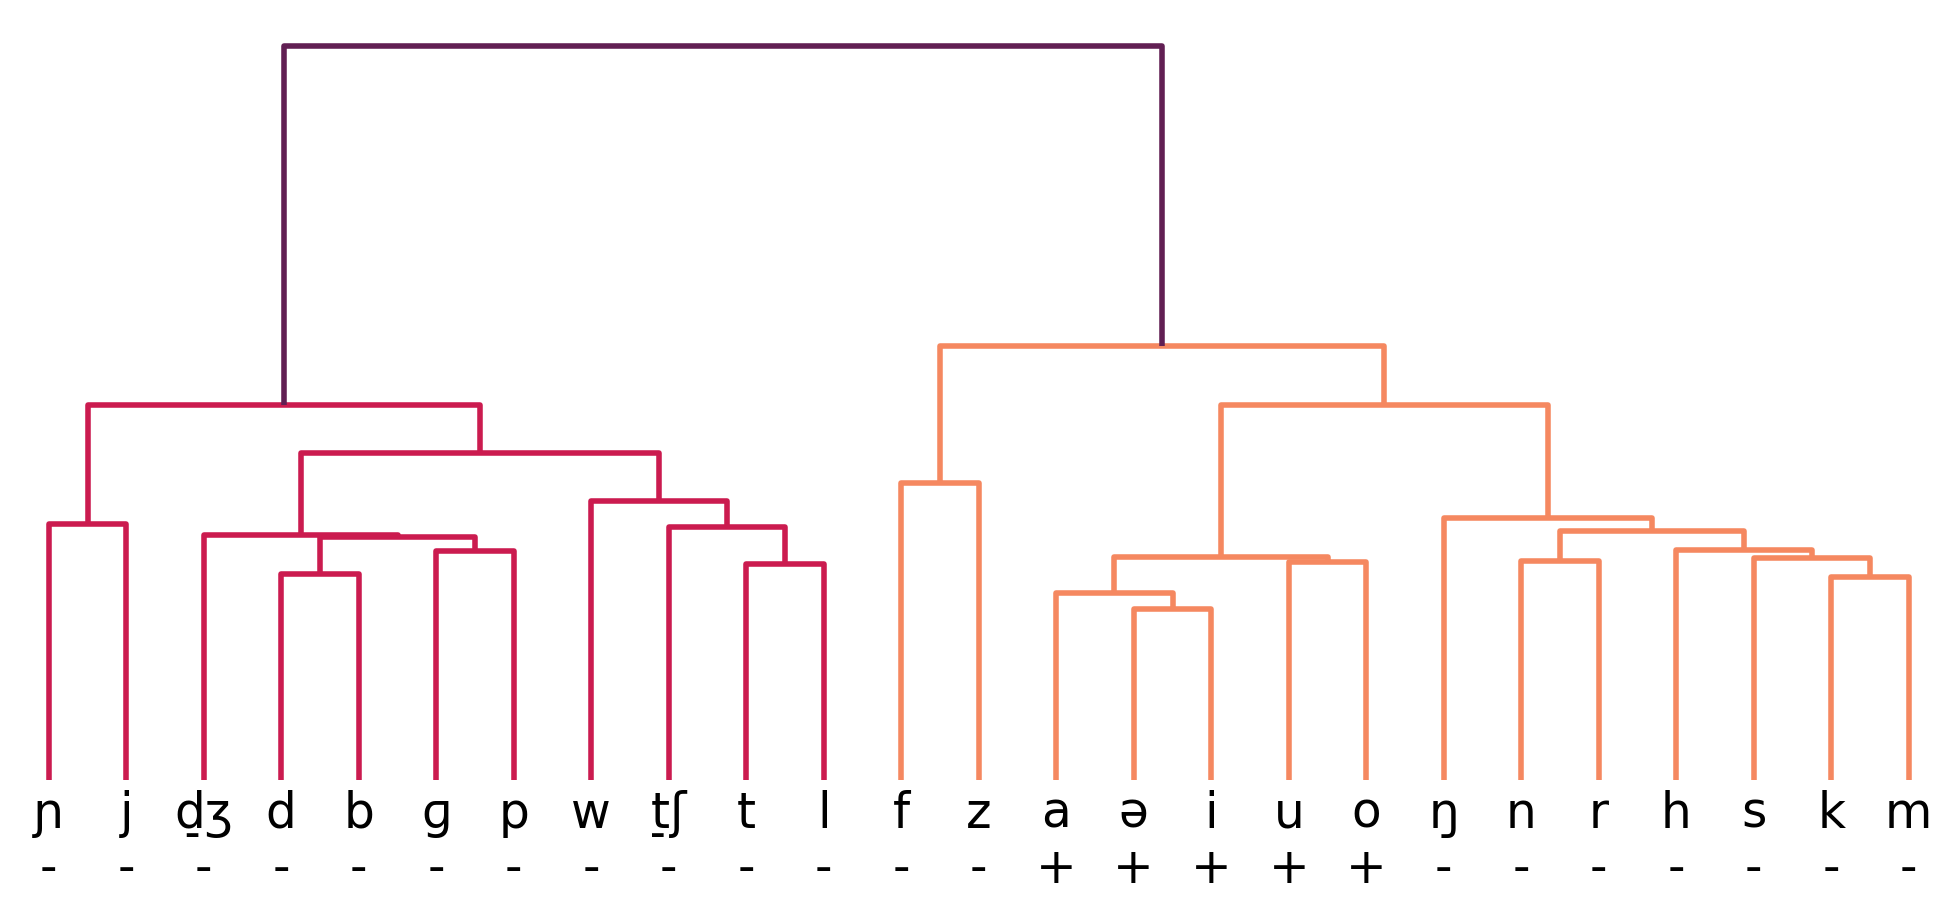

Japanese


100%|██████████| 31/31 [00:00<00:00, 423.68it/s]


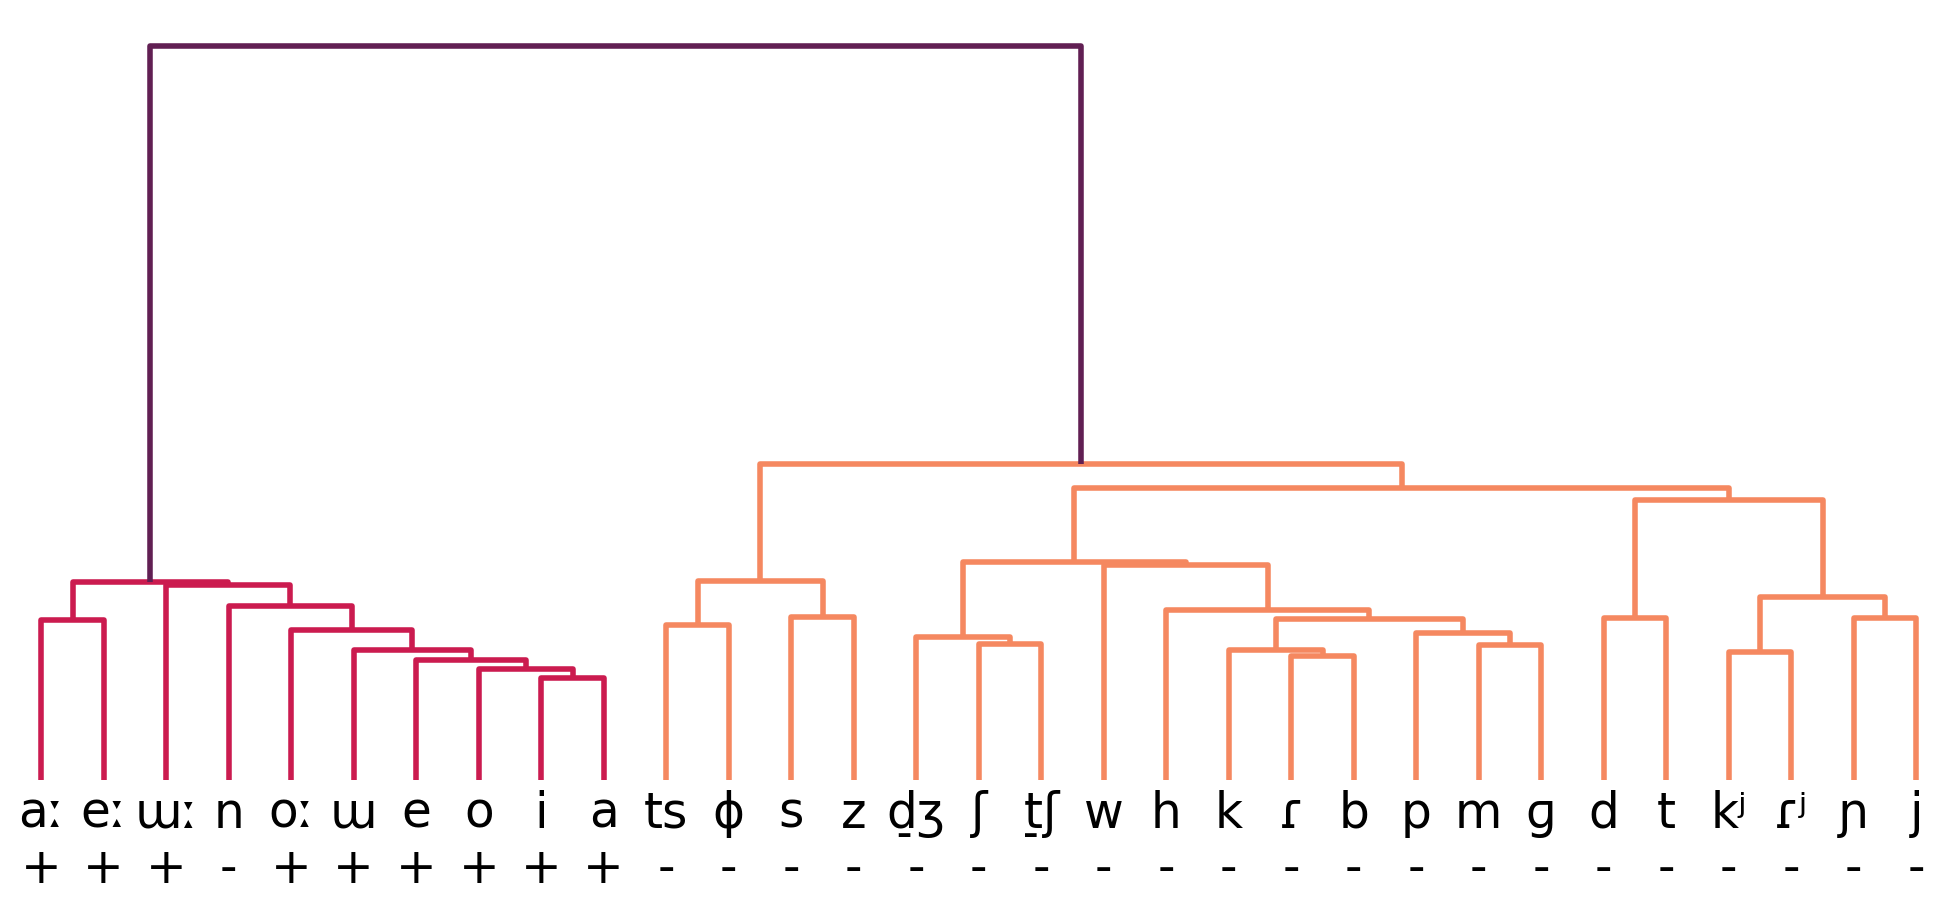

In [32]:
import seaborn

def get_average_embeddings(language, context='ctx_embedding'):
    # For each phoneme in the language, get 10 embeddings and average them
    # (Note that if context='embedding' than this averaging is not strictly necessary
    # since the embeddings are the same for each instance of the phoneme)
    emd = embedding_data[language]
    average_embeddings = {}
    phoneme_map = phoneme_maps[language]
    for phoneme in tqdm(emd['id'].unique()):
        phoneme_emd = emd[emd['id'] == phoneme][context].tolist()[:20]
        if len(phoneme_emd) < 10:
            print('Skipping phoneme', phoneme, 'with less than 10 examples')
            continue
        average_embeddings[phoneme] = np.mean(phoneme_emd, axis=0)

    return average_embeddings

def plot_dendogram(language='English', feature='syllabic', context='ctx_embedding'):
    from scipy.cluster.hierarchy import dendrogram, linkage

    average_embeddings = get_average_embeddings(language)
    phoneme_map = phoneme_maps[language]
    tokenizer = tokenizers[language]
    feature_to_str = lambda x : '+' if x == 2 else '-' if x == 1 else ''
    labels = [tokenizer.convert_ids_to_tokens(phoneme) + '\n' + feature_to_str(phoneme_map[phoneme][FEATURES.index(feature)])
              for phoneme in average_embeddings.keys()]

    X = np.array(list(average_embeddings.values()))
    Z = linkage(X, 'ward')

    plt.figure(figsize=(25, 10))
    seaborn.set_palette("rocket", 3)
    plt.rcParams['lines.linewidth'] = 4
    dendrogram(Z, labels=labels)
    plt.xticks(rotation=0)
    plt.tick_params(axis='x', which='major', labelsize=35)
    plt.tick_params(axis='y', which='both', left=False, labelleft=False)
    # Remove border
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
    plt.show()

for language in models.keys():
    print(language)
    plot_dendogram(language, 'syllabic', 'ctx_embedding')


In [18]:
print(tokenizers['Dutch'].convert_ids_to_tokens(embedding_data['Dutch']['id'].unique()))
print(tokenizers['Dutch'].vocab)

['n', 's', 't', 'ə', 'k', 'oː', 'ɪ', 'ŋ', 'v', 'ɑ', 'd', 'ʋ', 'ɛː', 'ɾ', 'l', 'ɣ', 'ãː', 'ʌu', 'ɛ', 'u', 'f', 'j', 'ɦ', 'p', 'ɛi', 'y', 'm', 'x', 'i', 'ɔ', 'z', 'b', 'ʏ', 'ɔː', 'øː', 'tʲ', 'œy', 'ʃ', 'w']
{'oː': 5, 'u': 31, 'ʏ': 28, 'ŋ': 33, 'ɑ': 16, 'v': 21, 'ɡ': 47, 'ãː': 7, 'ɔ': 29, 'ɪ': 14, 'ɦ': 8, 'œy': 39, 'ɔː': 36, 'UTT_BOUNDARY': 3, 'i': 11, 'd': 10, 'p': 13, 'øː': 34, 'ɲ': 44, 'ʃ': 42, 'ʋ': 24, 'k': 15, 'WORD_BOUNDARY': 2, 'ʒ': 45, 'n': 19, 'j': 6, 'l': 17, 'm': 26, 's': 20, 'PAD': 1, 'w': 41, 'z': 4, 'iː': 46, 'ɛ': 12, 'ɛː': 18, 'y': 38, 'ɾ': 9, 'f': 32, 'tʲ': 40, 'UNK': 0, 't': 25, 'b': 35, 'ɣ': 27, 'd̠ʒ': 48, 'x': 30, 'ə': 22, 'ã': 49, 't̠ʃ': 43, 'ɛi': 23, 'ʌu': 37}


In [19]:
print(phoneme_maps['Dutch'][33])

[0, 1, 1, 1, 1, 2, 2, 1, 0, 1, 1, 1, 2, 1, 1, 0, 0, 1, 0, 0, 0, 2, 2, 1, 1, 1, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0]
